### __Loading data + synching them__

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from modules.utils import *
from modules.localization import *

In [3]:
dataset_num = 20 # or 21
dataset_names = {
    "encoder": "Encoders",
    "lidar": "Hokuyo",
    "imu": "Imu",
    "rgbd": "Kinect",
}

data = load_data(dataset_num, dataset_names)
encoder = Encoder(data["encoder"])
lidar = Lidar(data["lidar"])
imu = Imu(data["imu"])
rgbd = Kinect(data["rgbd"])

synchronize_sensors(encoder, imu, lidar, base_sensor_index=0)

In [ ]:
print("encoder.counts_synced.shape:", encoder.counts_synced.shape)
print("encoder.counts.shape:", encoder.counts.shape)

print("")

print("lidar.ranges_synced.shape:", lidar.ranges_synced.shape)
print("lidar.ranges.shape:", lidar.ranges.shape)

print("")

print("imu.acc_synced.shape:", imu.acc_synced.shape)
print("imu.acc.shape:", imu.acc.shape)

print("")

print("imu.gyro_synced.shape:", imu.gyro_synced.shape)
print("imu.gyro.shape:", imu.gyro.shape)

### __Generate pose estimates using differential-drive motion model__

In [9]:
dt = 1./40.
states = [[0, 0, 0]]
for i in range(1, encoder.counts_synced.shape[0]):
    v = v_from_encoder(encoder.counts_synced[i])
    w = imu.gyro_synced[i]
    state = diff_drive_motion_model(states[-1], v, w, dt)
    states.append(state)
states = np.array(states)

### __Plot robot's trajectory using pose estimates__

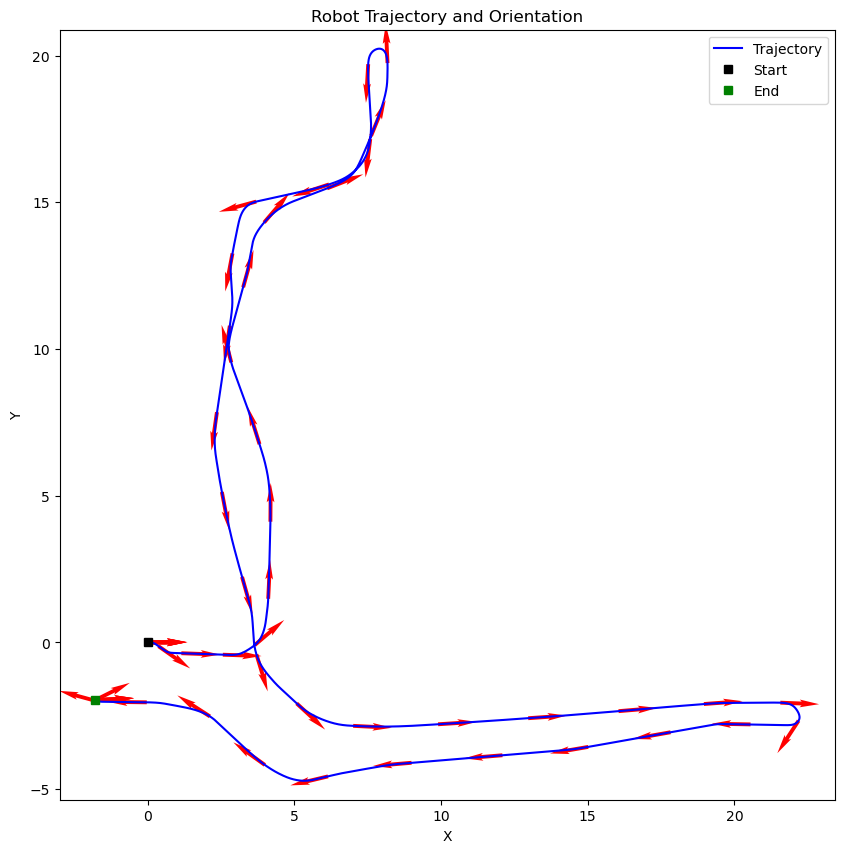

In [48]:
import matplotlib.pyplot as plt

# Extract x, y coordinates and yaw angles
x = states[:, 0]
y = states[:, 1]
yaw = states[:, 2]

# Plot trajectory
plt.figure(figsize=(10, 10))
plt.plot(x, y, label='Trajectory', color='blue')

plt.plot(x[0], y[0], 's', color='black', label='Start')
plt.plot(x[-1], y[-1], 's', color='green', label='End')


# Plot robot's coordinate frame every 100 steps
for i in range(0, len(x), 100):
    # Calculate the end points of the orientation vector, adjusting length here
    dx = np.cos(yaw[i]) * 0.5  # Adjust multiplier to control arrow length
    dy = np.sin(yaw[i]) * 0.5  # Adjust multiplier to control arrow length
    
    # Plot the orientation vector as an arrow
    plt.quiver(x[i], y[i], dx, dy, color='red', scale=10, width=0.005, headwidth=2, headlength=5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Robot Trajectory and Orientation')
plt.legend()
plt.axis('equal')
plt.show()